In [196]:
# install Cache of Allen Brain Atlas
#pip install "abc_atlas_access[notebooks] @ git+https://github.com/alleninstitute/abc_atlas_access.git"
#get_ipython().kernel.do_shutdown(restart=True)


In [197]:
# libraries
from pathlib import Path
from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache
import anndata
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import anndata as ad
import scipy
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay, classification_report,f1_score
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [198]:
###############################################################################
# Download dataset
###############################################################################


download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(download_base)

abc_cache.current_manifest
abc_cache.list_manifest_file_names

abc_cache.load_latest_manifest()
print("after latest manifest loaded:", abc_cache.current_manifest)

metadataCCF = abc_cache.get_directory_metadata('MERFISH-C57BL6J-638850-CCF')
cell = abc_cache.get_metadata_dataframe(
    directory='MERFISH-C57BL6J-638850-CCF',
    file_name='cell_metadata_with_parcellation_annotation'
).set_index('cell_label')
print("Number of cells = ", len(cell))

adata = anndata.read_h5ad('C:/data/abc_atlas/expression_matrices/MERFISH-C57BL6J-638850/20230830/C57BL6J-638850-log2.h5ad', backed='r')
# Create a landing Pandas DataFrame for the data.


after latest manifest loaded: releases/20250531/manifest.json
Number of cells =  3739961


In [199]:
###############################################################################
# Inspect dataset
###############################################################################

list(cell.columns.values)

unique_values = cell['neurotransmitter'].unique() # part of the brain
print(unique_values)

unique_values = cell['class'].unique() # part of the brain
print(unique_values)

cell['parcellation_division'].value_counts()

[nan 'Glut' 'Chol' 'GABA-Glyc' 'GABA' 'Dopa' 'Glut-GABA' 'Hist' 'Sero'
 'Nora']
['04 DG-IMN Glut' '23 P Glut' '31 OPC-Oligo' '24 MY Glut' '19 MB Glut'
 '26 P GABA' '20 MB GABA' '05 OB-IMN GABA' '30 Astro-Epen' '33 Vascular'
 '28 CB GABA' '27 MY GABA' '09 CNU-LGE GABA' '01 IT-ET Glut' '12 HY GABA'
 '29 CB Glut' '11 CNU-HYa GABA' '13 CNU-HYa Glut' '03 OB-CR Glut'
 '34 Immune' '10 LSX GABA' '32 OEC' '02 NP-CT-L6b Glut' '08 CNU-MGE GABA'
 '07 CTX-MGE GABA' '15 HY Gnrh1 Glut' '25 Pineal Glut' '06 CTX-CGE GABA'
 '18 TH Glut' '14 HY Glut' '16 HY MM Glut' '21 MB Dopa' '17 MH-LH Glut'
 '22 MB-HB Sero']


Isocortex                  935742
STR                        401346
CB                         383127
HPF                        304642
MB                         281852
OLF                        274354
MY                         147562
P                          136569
TH                         133805
HY                         132902
lfbs                       104430
PAL                         77885
unassigned                  68586
cm                          63678
CTXsp                       60747
cbf                         60456
mfbs                        55894
VL                          35475
scwm                        18473
brain-unassigned            17945
V3                          12322
fiber tracts-unassigned     12317
V4                          11736
eps                          5206
AQ                           2910
Name: parcellation_division, dtype: int64

In [200]:
###############################################################################
# Filter dataset
###############################################################################

neuron_groups = [
    'Glut', 'Chol', 'GABA-Glyc', 'GABA', 'Dopa', 'Glut-GABA', 'Hist', 'Sero',
 'Nora'
]

# Filter metadata df for neurons and get cell_labels
neuron_cells = cell[cell['neurotransmitter'].isin(neuron_groups)]
neuron_cell_labels = neuron_cells.index

# Subset adata by matching adata.obs.index with neuron_cell_labels
adata_neurons = adata[adata.obs.index.isin(neuron_cell_labels)].to_memory()
print(f"Number of neuron cells: {adata_neurons.n_obs}")
print(adata_neurons.obs.head())

regions_of_interest = ['MB','Isocortex','P']
# Filter metadata for those regions
filtered_cells = cell[cell['parcellation_division'].isin(regions_of_interest)]
print(f"Number of filtered cells: {len(filtered_cells)}")

# Filter using the 'cell_label' column from filtered_cells
adata_filtered = adata_neurons[adata_neurons.obs.index.isin(filtered_cells.index)].copy()

###############################################################################
# Map metadata to dataset
###############################################################################

# Map parcellation structure info onto adata
adata_filtered.obs['region'] = filtered_cells['parcellation_division']
# Map neurotransmitter info onto adata
adata_filtered.obs['neurotransmitter'] = filtered_cells['neurotransmitter']

# Map neurotransmitter info onto adata
adata_filtered.obs['subregion'] = filtered_cells['parcellation_structure']
adata_filtered.obs['subregionLDT'] = filtered_cells['parcellation_structure'].isin(['LDT'])

adata_filtered.obs['class'] = filtered_cells['class']



Number of neuron cells: 2133196
                    brain_section_label
cell_label                             
1019171911101460569   C57BL6J-638850.05
1019171911101550321   C57BL6J-638850.05
1019171911100841066   C57BL6J-638850.05
1019171911101400425   C57BL6J-638850.05
1019171911101380264   C57BL6J-638850.05
Number of filtered cells: 1354163


In [201]:
###############################################################################
# Dimensionality reduction and clustering
###############################################################################

sc.tl.pca(adata_filtered, n_comps=40)

# UMAP & Leiden

sc.pp.neighbors(adata_filtered, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_filtered)

sc.tl.leiden(adata_filtered, resolution=0.5)



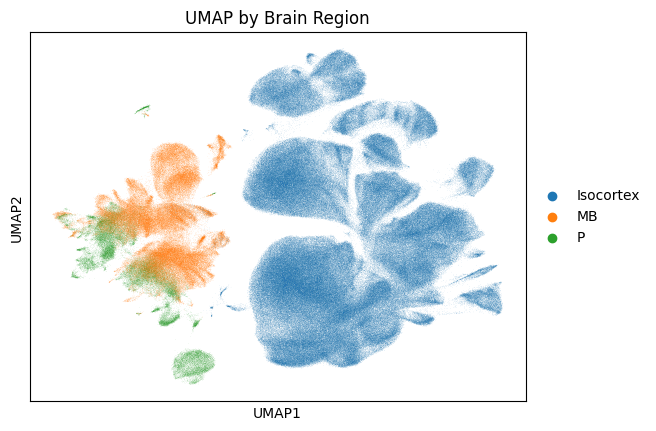

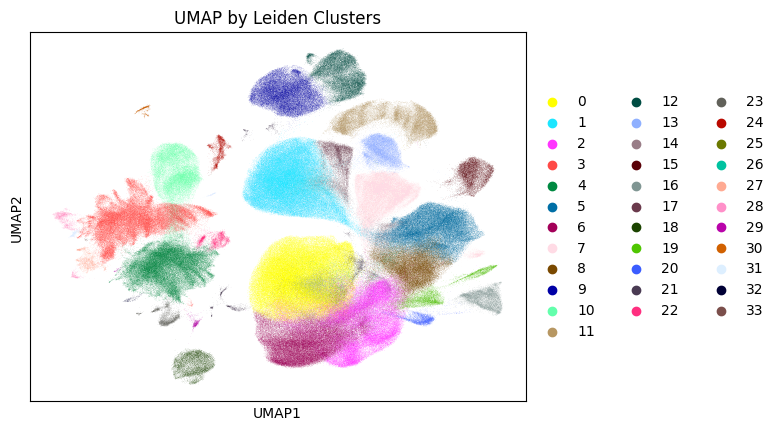

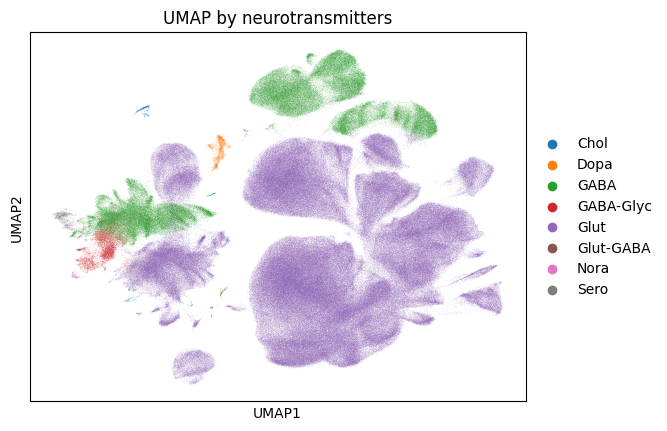

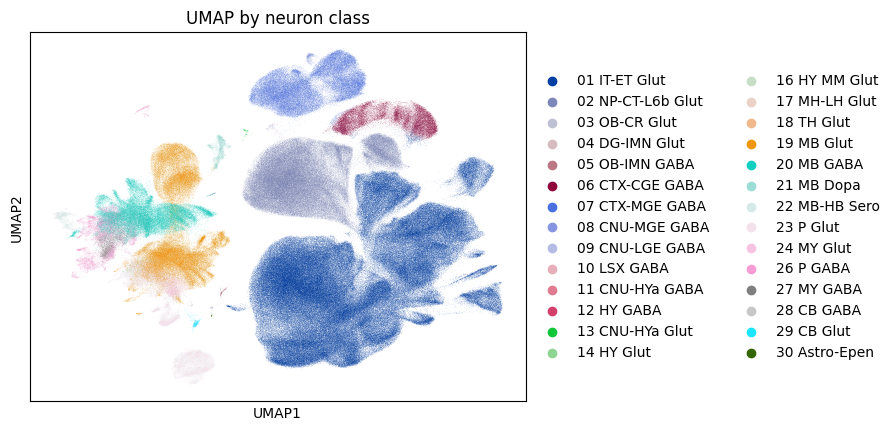

In [202]:
###############################################################################
# Plot with UMAP on condition of interest
###############################################################################

# Plot: colored by region
sc.pl.umap(adata_filtered, color='region', title='UMAP by Brain Region')
# Plot: colored by Leiden cluster
sc.pl.umap(adata_filtered, color='leiden', title='UMAP by Leiden Clusters')
# Plot: colored by Leiden cluster
sc.pl.umap(adata_filtered, color='neurotransmitter', title='UMAP by neurotransmitters')
# Plot: colored by Leiden cluster
sc.pl.umap(adata_filtered, color='class', title='UMAP by neuron class')



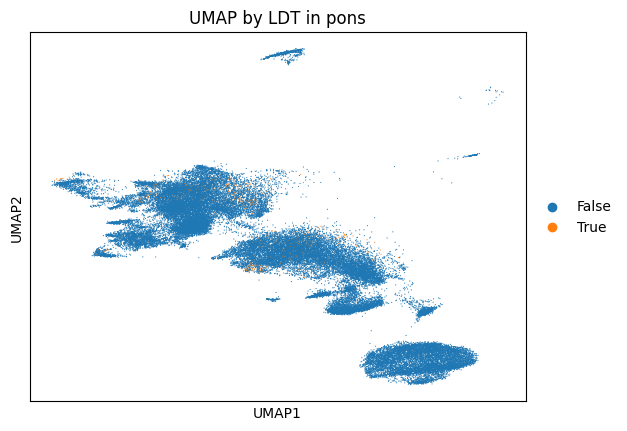

In [203]:
###############################################################################
# Add a specific focus on the LDTg
###############################################################################
filtered_cellsLTD = cell[cell['parcellation_structure'].isin(['LDT'])]
adata_filtered.obs['subregionLDT'] = filtered_cells['parcellation_structure'].isin(['LDT'])
sc.pl.umap(adata_filtered[adata_filtered.obs['region']=='P'], color='subregionLDT', title='UMAP by LDT in pons')


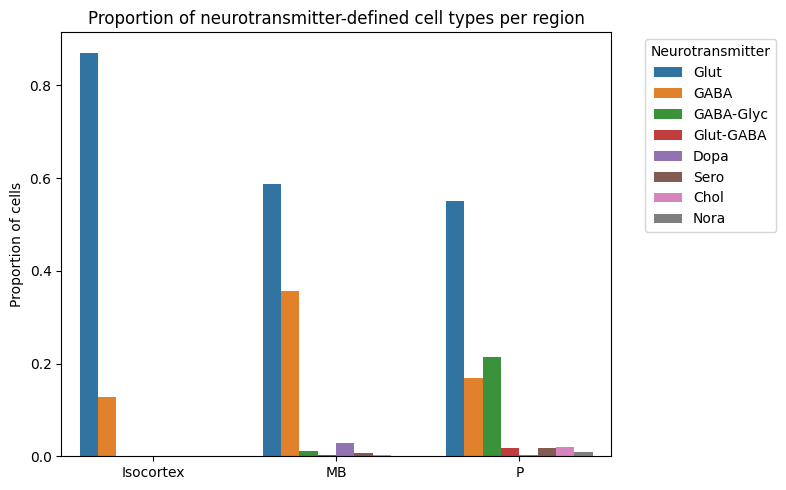

In [204]:
###############################################################################
# Neurotransmitters per regions
###############################################################################


# Extract region and neurotransmitter annotations
meta = adata_filtered.obs[['region', 'neurotransmitter']].copy()

# Count cells per category
counts = (
    meta.groupby(['region', 'neurotransmitter'])
    .size()
    .reset_index(name='count')
)

# Compute proportion within each region
counts['proportion'] = counts.groupby('region')['count'].apply(lambda x: x / x.sum())
counts.head()

# Sort neurotransmitter categories in a consistent biological order
order_nt = ['Glut', 'GABA', 'GABA-Glyc', 'Glut-GABA', 'Dopa', 'Sero', 'Chol', 'Nora']

plt.figure(figsize=(8, 5))
sns.barplot(
    data=counts,
    x='region',
    y='proportion',
    hue='neurotransmitter',
    hue_order=order_nt
)

plt.title('Proportion of neurotransmitter-defined cell types per region')
plt.ylabel('Proportion of cells')
plt.xlabel('')
plt.legend(title='Neurotransmitter', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [205]:
###############################################################################
# generalization of the classification of cortex/midbrain/pons
###############################################################################

results = []

regions = adata_filtered.obs['region'].unique()

adata_filtered2 = adata_filtered[
    adata_filtered.obs['neurotransmitter'].isin(['Glut', 'GABA'])
].copy()

for region in regions:
    print(f"\nAnalyzing region: {region}")
    adata_sub = adata_filtered2[adata_filtered2.obs['region'] == region].copy()

    X = adata_sub.obsm['X_pca']
    y = adata_sub.obs['neurotransmitter'].astype(str)
    # Skip regions with too few cells or labels
    if len(np.unique(y)) < 2 or len(y) < 100 or min([len(y[y==yi]) for yi in np.unique(y)])<10:
        print(f"Skipping {region} (too few cells or labels)")
        continue

    region_scores = []

    # Repeat 10 random splits to estimate variability
    for seed in range(50):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.7, stratify=y, random_state=seed
        )

        clf = make_pipeline(
            StandardScaler(with_mean=False),
            LogisticRegression(max_iter=1000, n_jobs=-1, solver='lbfgs')
        )

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        results.append({'region': region, 'iteration': seed, 'accuracy': acc})

results_df = pd.DataFrame(results)



Analyzing region: P

Analyzing region: MB

Analyzing region: Isocortex


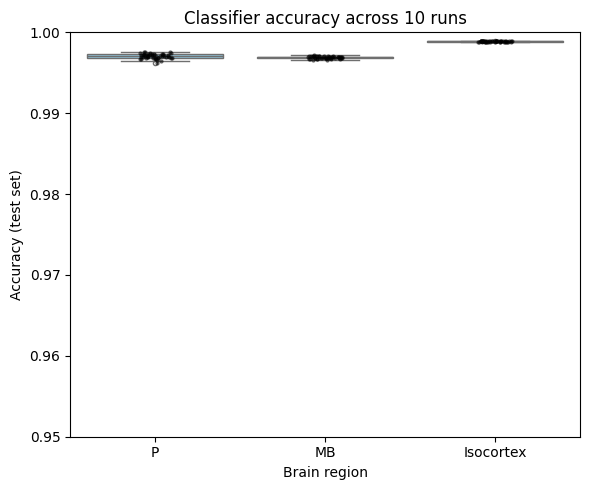

In [206]:
# success rate 
plt.figure(figsize=(6,5))
sns.boxplot(data=results_df, x='region', y='accuracy', color='skyblue', fliersize=3)
sns.stripplot(data=results_df, x='region', y='accuracy', color='black', size=3, alpha=0.6)
plt.title('Classifier accuracy across 10 runs')
plt.ylabel('Accuracy (test set)')
plt.xlabel('Brain region')
plt.ylim(0.95, 1)
plt.tight_layout()
plt.show()

In [207]:
###############################################################################
# generalization of the classification of inbetween regions of the Pons area
###############################################################################
results = []

regions = adata_filtered.obs['subregion'][adata_filtered.obs['region']=='P'].unique()

adata_filtered2 = adata_filtered[
    adata_filtered.obs['neurotransmitter'].isin(['Glut', 'GABA','GABA-Glyc'])
].copy()
# prepare storage
all_predictions = []

for region in regions:
    print(f"\nAnalyzing region: {region}")
    adata_sub = adata_filtered2[adata_filtered2.obs['subregion'] == region].copy()

    X = adata_sub.obsm['X_pca']
    y = adata_sub.obs['neurotransmitter'].astype(str)
    
    # Skip regions with too few cells or labels
    if len(np.unique(y)) < 2 or len(y) < 100 or min([len(y[y==yi]) for yi in np.unique(y)])<10:
        print(f"Skipping {region} (too few cells or labels)")
        continue

    region_scores = []

    # Repeat 10 random splits to estimate variability
    for seed in range(10):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.7, stratify=y, random_state=seed
        )

        clf = make_pipeline(
            StandardScaler(with_mean=False),
            LogisticRegression(max_iter=1000, n_jobs=-1, solver='lbfgs')
        )

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        results.append({'region': region, 'iteration': seed, 'accuracy': acc})
        f1 = f1_score(y_test, y_pred, average='macro')

        region_scores.append((acc, f1))

        # store predictions and metadata
        df_pred = pd.DataFrame({
            'region': region,
            'iteration': seed,
            'true_label': y_test,
            'pred_label': y_pred
        })
        all_predictions.append(df_pred)

    
results_df_pons = pd.DataFrame(results)



Analyzing region: P-unassigned

Analyzing region: SG
Skipping SG (too few cells or labels)

Analyzing region: PCG

Analyzing region: PB

Analyzing region: PDTg
Skipping PDTg (too few cells or labels)

Analyzing region: PSV

Analyzing region: LC
Skipping LC (too few cells or labels)

Analyzing region: PRNc

Analyzing region: SLC
Skipping SLC (too few cells or labels)

Analyzing region: SOC
Skipping SOC (too few cells or labels)

Analyzing region: NI

Analyzing region: RPO
Skipping RPO (too few cells or labels)

Analyzing region: SLD

Analyzing region: B
Skipping B (too few cells or labels)

Analyzing region: V

Analyzing region: SUT

Analyzing region: P5

Analyzing region: I5
Skipping I5 (too few cells or labels)

Analyzing region: DTN

Analyzing region: LDT

Analyzing region: Acs5
Skipping Acs5 (too few cells or labels)

Analyzing region: PC5

Analyzing region: PRNr

Analyzing region: CS

Analyzing region: TRN

Analyzing region: NLL

Analyzing region: PG
Skipping PG (too few cells or 

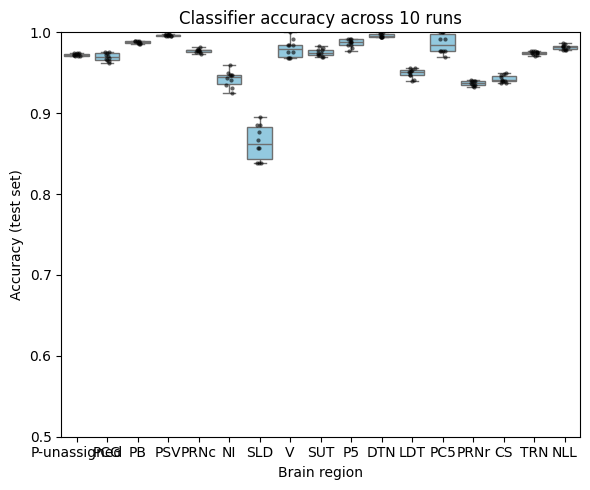

In [208]:

# success rate
plt.figure(figsize=(6,5))
sns.boxplot(data=results_df_pons, x='region', y='accuracy', color='skyblue', fliersize=3)
sns.stripplot(data=results_df_pons, x='region', y='accuracy', color='black', size=3, alpha=0.6)
plt.title('Classifier accuracy across 10 runs')
plt.ylabel('Accuracy (test set)')
plt.xlabel('Brain region')
plt.ylim(0.5, 1)
plt.tight_layout()
plt.show()

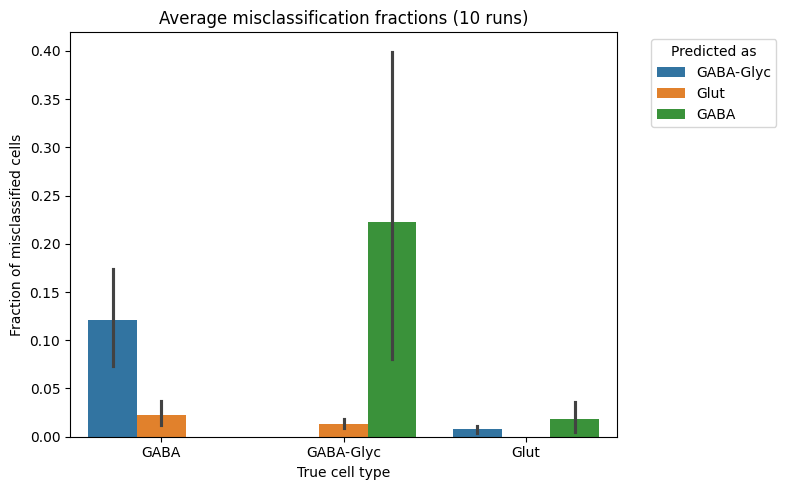

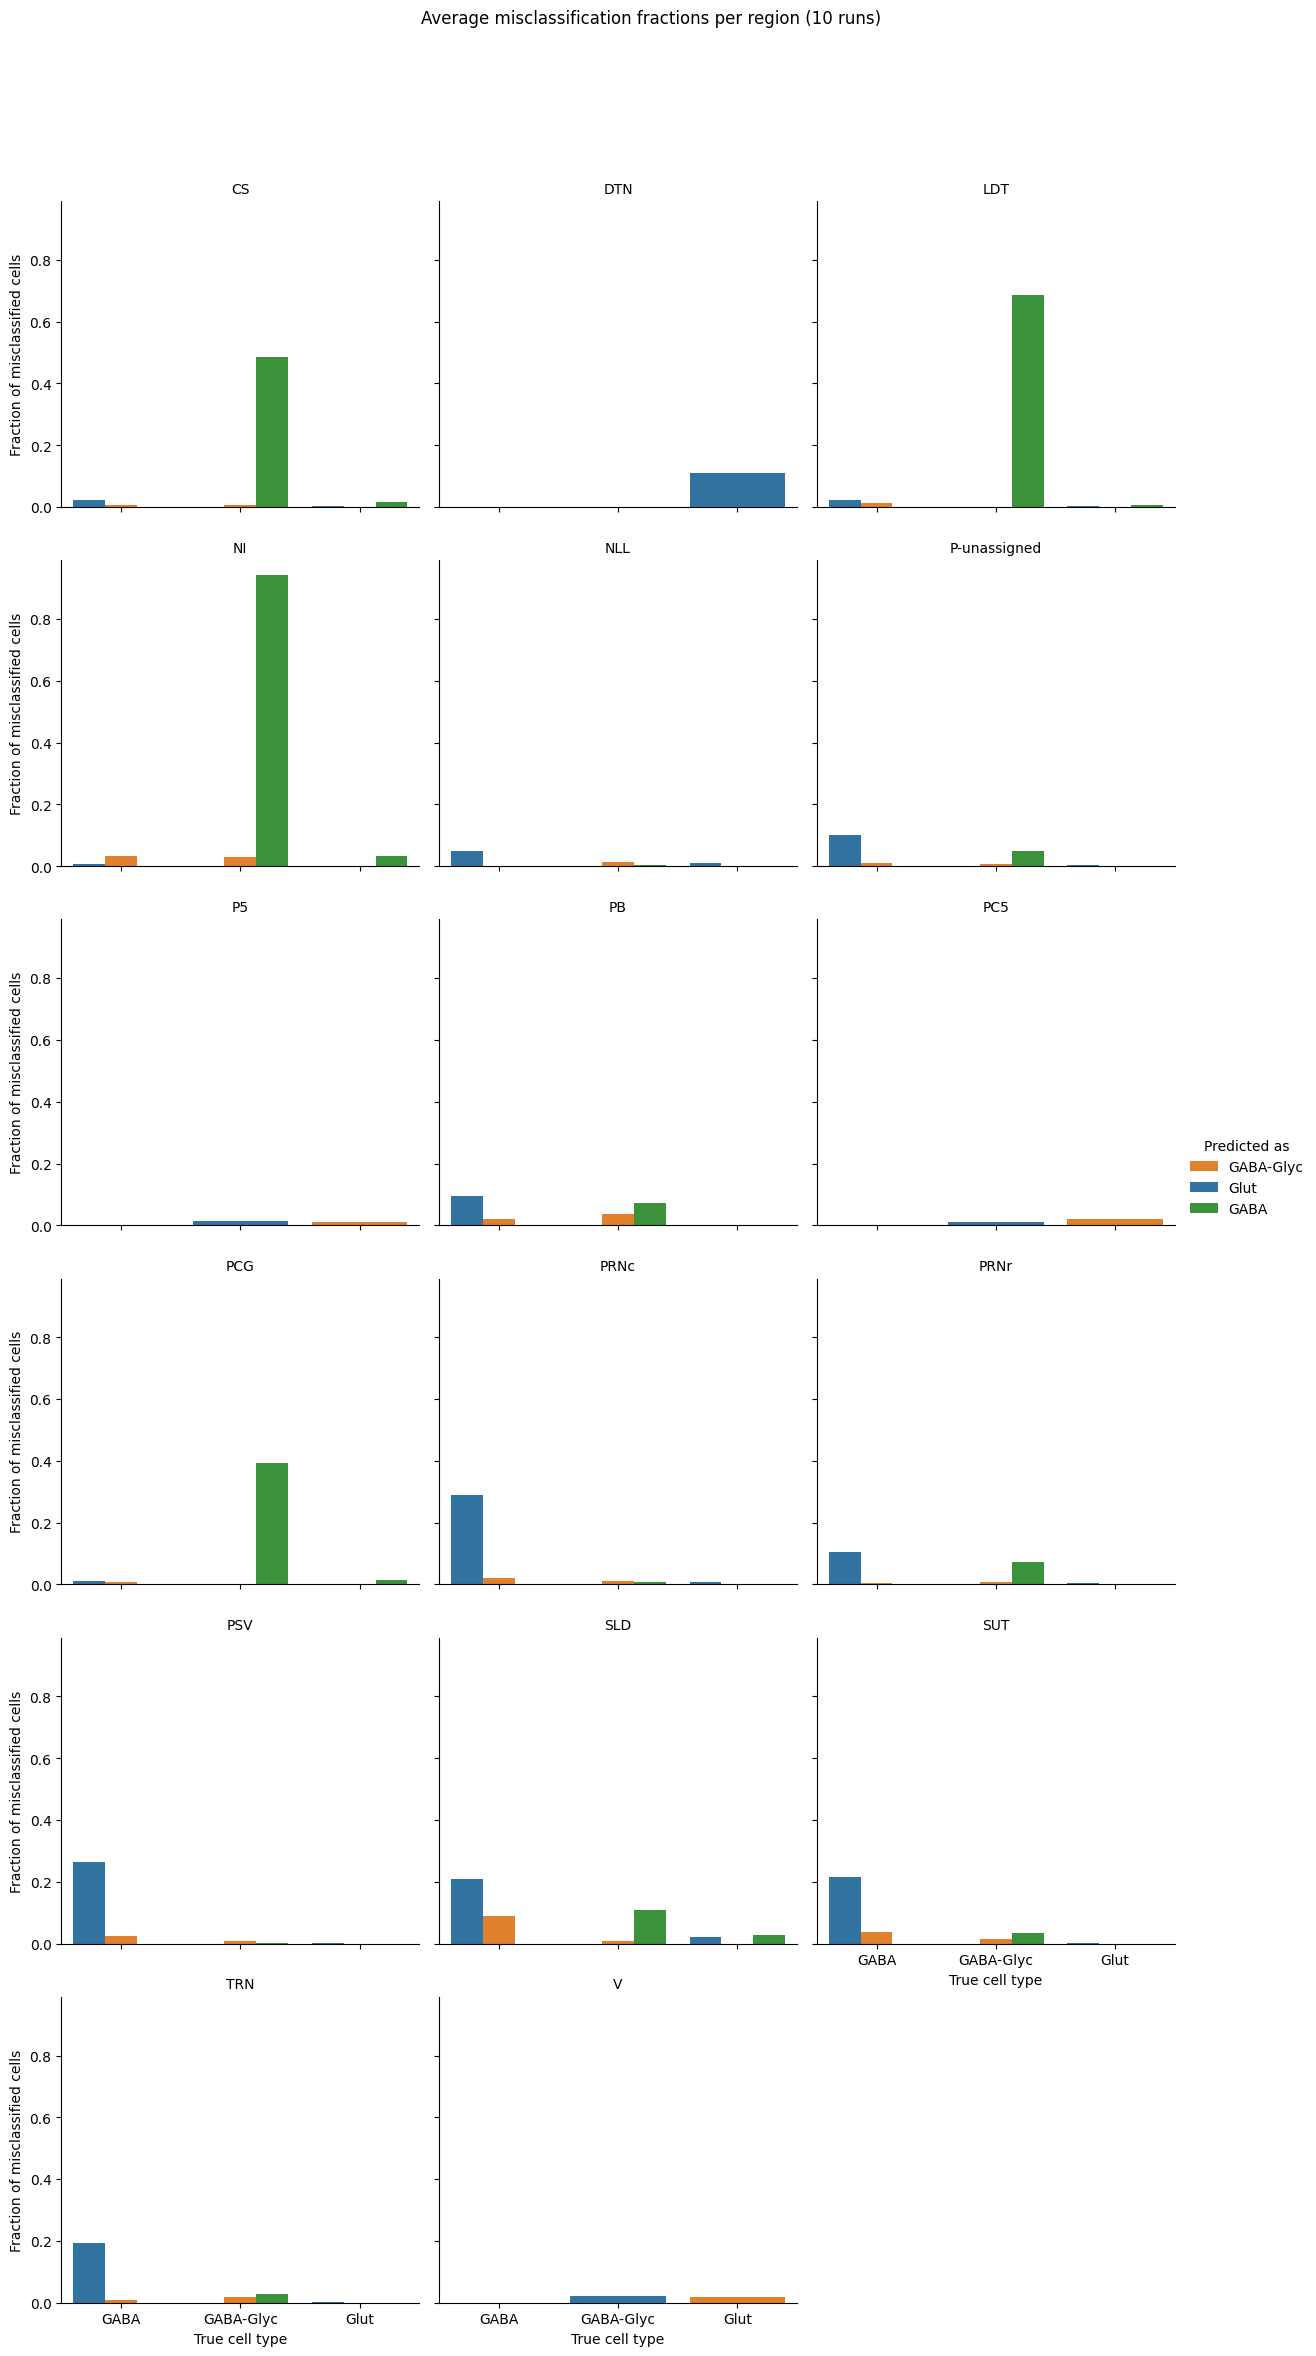

In [209]:

# Analysis of mistakes across cells type

predictions_df = pd.concat(all_predictions, ignore_index=True)
mistakes_df = predictions_df[predictions_df['true_label'] != predictions_df['pred_label']].copy()

error_rate = (
    mistakes_df.groupby(['region', 'true_label', 'pred_label'])
    .size()
    .reset_index(name='count')
)

# Normalize by total count of each true label (over all runs)
total_counts = predictions_df.groupby(['region', 'true_label']).size().reset_index(name='total')
error_rate = error_rate.merge(total_counts, on=['region', 'true_label'])
error_rate['fraction'] = error_rate['count'] / error_rate['total']

plt.figure(figsize=(8, 5))
sns.barplot(data=error_rate, x='true_label', y='fraction', hue='pred_label')
plt.title('Average misclassification fractions (10 runs)')
plt.ylabel('Fraction of misclassified cells')
plt.xlabel('True cell type')
plt.legend(title='Predicted as', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- Compute total counts and normalized fractions ---
total_counts = predictions_df.groupby(['region', 'true_label']).size().reset_index(name='total')
error_rate = (
    mistakes_df.groupby(['region', 'true_label', 'pred_label'])
    .size()
    .reset_index(name='count')
    .merge(total_counts, on=['region', 'true_label'])
)
error_rate['fraction'] = error_rate['count'] / error_rate['total']

# --- Plot: one panel per region ---
g = sns.FacetGrid(
    error_rate, 
    col='region', 
    col_wrap=3,  # adjust depending on how many regions you have
    sharey=True,
    height=4
)

g.map_dataframe(
    sns.barplot,
    x='true_label',
    y='fraction',
    hue='pred_label',
    palette='tab10'
)

g.add_legend(title='Predicted as')
g.set_axis_labels('True cell type', 'Fraction of misclassified cells')
g.set_titles(col_template='{col_name}')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Average misclassification fractions per region (10 runs)')
plt.show()
